In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.utils import *
from metrics.query import DataFrameQuery
from common.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from pathlib import Path
from collections import Counter

In [2]:
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
# change working dir
os.chdir("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

# Main

# Functions

In [3]:
def constructing_labels(label: str, hidden_states_df: pd.DataFrame, hidden_states: np.ndarray) -> np.ndarray:
    labels_literals = hidden_states_df[label].unique()
    labels_literals.sort()
    
    map_labels = {class_name: n for n,class_name in enumerate(labels_literals)}
    
    label_per_row = hidden_states_df[label].reset_index(drop=True)
    label_per_row = np.array([map_labels[class_name] for class_name in label_per_row])[:hidden_states.shape[0]]
    
    return label_per_row, map_labels

In [4]:
tsm =  TensorStorageManager()  

# Pipeline

In [5]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
_PATH_RESULT = Path("/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

class Pipeline():
    def __init__(self):
        self.df = None
    
    def preprocess(self, query):
        hidden_states, logits, hidden_states_stat = self.retrieve(query)
        
        filtered_hidden_states, filtered_logits, filter_hidden_states_stat, repeated_indices = filter_indentical_rows(hidden_states, logits, hidden_states_stat)
        return filtered_hidden_states, \
               filtered_logits, \
               filter_hidden_states_stat, \
               repeated_indices
        

            
    def compute(self):
        z = 1
        models = ["meta-llama/Llama-3-8b-hf"]
        rows = []
        for model in models:
            for shot in [0,5]:
                if "chat" in model and shot == 5:
                    continue
                elif "70" in model and shot == 5:
                    shot = 4
                dict_query = {"method":"last",
                              "model_name": model,
                              "train_instances": shot}
                hidden_states, logits, hidden_states_stat, repeated_indices = self.preprocess(dict_query)
                for layer in [33,3,7,20]:
                    print(f'Iteration with model:{model}, shot:{shot}, layer:{layer}')
                    # compute clustering
                    print(hidden_states.shape)
                    if layer == 33:
                        data = Data(logits)
                    else:
                        data = Data(hidden_states[:,layer,:])
                    data.compute_distances(maxk=1000)
                    clusters_assignement = data.compute_clustering_ADP(Z=z)
                    
                    # filter small cluster
                    cluster_to_remove = np.where(np.bincount(clusters_assignement)<20)
                    bad_indices = np.where(np.isin(clusters_assignement, cluster_to_remove[0]))[0]
                    clusters_assignement = np.delete(clusters_assignement, bad_indices)
                    filtered_hidden_states_stat = hidden_states_stat.drop(bad_indices)
                    
                    
                    # compute centroids
                    distance_matrix = self.compute_centroids(data, cluster_to_remove)
                    
                    # compute attributes
                    cluster_counts, most_represented = self.attributes_df(clusters_assignement, 
                                                                          filtered_hidden_states_stat)
                    
                    row = [model, shot, layer, most_represented, distance_matrix, cluster_counts]
                    rows.append(row)
                checkpoint_path = Path(_PATH_RESULT / f"checkpoint.pkl")
                
                with open(checkpoint_path, "wb") as f:
                    pickle.dump(rows, f)
            
        df = pd.DataFrame(rows, columns = ["model", 
                                           "shot", 
                                           "layer", 
                                           "most_represented", 
                                           "distance_matrix", 
                                           "cluster_counts"])
        self.df = df
        self.df.to_pickle(_PATH_RESULT / "df_3_8.pkl")
                    
    def plot(self):
        for index, row in self.df.iterrows():
            model = row["model"]
            shot = row["shot"]
            layer = row["layer"]
            most_represented = row["most_represented"]
            distance_matrix = row["distance_matrix"]
            cluster_counts = row["cluster_counts"]    
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            ax.set_title('Cluster Visualization')
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
            plt.title(f"Model: {model}, Shot: {shot}, Layer: {layer}") 
            plt.show()
            print(model.split("/")[1])
            plt.savefig(_PATH_RESULT / f"model_{model.split('/')[1]}_shot_{shot}_layer_{layer}.png")
        
    def retrieve(self, query):
        tsm = TensorStorageManager()
        query = DataFrameQuery(query)
        hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")
        return hidden_states,logits, hidden_states_stat
        
    def attributes_df(self,  
                      clusters_assignement, 
                      hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        map_sub_ind = {class_name: n for n,class_name in enumerate(set(subjects))}
        map_ind_sub = {n: class_name for n,class_name in enumerate(set(subjects))}
        
        label_per_row = np.array([map_sub_ind[e] for e in subjects])
        cluster_sub = np.concatenate([np.expand_dims(label_per_row,axis =0),np.expand_dims(clusters_assignement,axis =0)], axis = 0)
        cluster_sub = cluster_sub.T
        
        stem,not_stem = self.stem(hidden_states_stat)
        sub_binary = list(map(lambda r: r in stem,list(map(lambda r: map_ind_sub[r],cluster_sub[:,0]))))
        
        df = pd.DataFrame({"type": sub_binary, "cluster": cluster_sub[:,1]})
        
        df["type"] = df["type"].astype(int)
        most_represented = df.groupby('cluster')['type'].agg(lambda x: x.mean()).reset_index()
        most_represented.rename(columns={"type":"percentage"}, inplace=True)
        
        cluster_counts = Counter(cluster_sub[:, 1])
        
        return cluster_counts, most_represented
    
    def stem(self, 
             hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        subjects_list = np.unique(subjects)
        stem_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'college_biology', 'college_chemistry',
                 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics',
                 'computer_security', 'conceptual_physics', 'electrical_engineering', 'high_school_biology',
                 'high_school_chemistry', 'high_school_computer_science', 'high_school_mathematics',
                 'high_school_physics', 'high_school_statistics', 'machine_learning', 'medical_genetics',
                 'professional_medicine', 'virology', 'elementary_mathematics']

        # Determine STEM and non-STEM
        is_stem = np.isin(subjects_list, stem_subjects)
        stem = subjects_list[is_stem]
        not_stem = subjects_list[~is_stem]
        
        return stem, not_stem
    
    def compute_centroids(self, data, cluster_to_remove):
        # compute centroids
        indices_per_cluster = data.cluster_indices
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = np.stack(centroids)
        centroids = np.delete(centroids,cluster_to_remove, axis=0)

        distance_matrix = pairwise_distances(centroids, metric='l2')
        
        return distance_matrix
            
    def run(self):
        self.compute()
        self.plot()
        
    
def find_identical_rows(matrix):
    
    # View the rows as a structured array to handle them as tuples
    dtype = [('row', matrix.dtype, matrix.shape[1])]
    structured_array = matrix.view(dtype)
    
    # Find unique rows and their indices
    _, inverse_indices = np.unique(structured_array, return_inverse=True)
    
    # Find where each row appears for the first time and their counts
    unique_rows, counts = np.unique(inverse_indices, return_counts=True)
    
    # Filter out unique rows, keeping only duplicates
    repeated_indices = [np.where(inverse_indices == i)[0] for i in unique_rows[counts > 1]]
    return repeated_indices

def filter_indentical_rows(hidden_states,logits, hidden_states_stat):
    # we pick only 7 because the repeated indices are supposed to be equal at each layer
    repeated_indices = find_identical_rows(hidden_states[:,7,:])
    indices_to_exclude = [index[0] for index in repeated_indices]
    filtered_hidden_states = np.delete(hidden_states, indices_to_exclude, axis=0)
    filtered_logits = np.delete(logits, indices_to_exclude, axis=0)
    filtered_hidden_states_stat = hidden_states_stat.drop(indices_to_exclude)
    filtered_hidden_states_stat.reset_index(inplace=True)
    print(filtered_hidden_states.shape)
    return filtered_hidden_states, filtered_logits, filtered_hidden_states_stat, repeated_indices

In [6]:
!export OMP_NUM_THREADS=1

# Cluster

In [ ]:
pipeline = Pipeline()
pipeline.run()

(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:33
(14012, 33, 4096)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [7]:
pipeline = Pipeline()
pipeline.run()

(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:33
(14012, 33, 4096)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [ ]:
!ls "/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/results/mmlu/llama3"

llama-3-70b  llama-3-70b-chat  llama-3-8b  llama-3-8b-chat


### Preprocessing

#### Retrieval

In [ ]:
dict_query = { "method":"last",
              "model_name":"meta-llama/Llama-3-8b-hf",
              "train_instances": "5"}
query = DataFrameQuery(dict_query)
hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")

In [ ]:
hidden_states

array([[[ 3.39e-02, -9.23e-02, -4.88e-02, ...,  8.89e-02,  1.34e-02,
          1.02e-02],
        [ 3.03e-02,  3.39e-02,  4.25e-02, ..., -3.86e-02,  1.36e-02,
          1.93e-02],
        [ 1.21e-01,  3.30e-01,  3.98e-02, ...,  6.37e-01, -5.79e-02,
          2.10e-01],
        ...,
        [ 1.79e-01, -9.72e-02,  2.66e-01, ..., -4.49e-01, -4.26e-01,
         -2.19e-02],
        [-6.54e-02, -1.23e-01,  1.65e-01, ..., -5.66e-01, -2.56e-01,
         -3.38e-01],
        [-2.03e+00,  4.80e-01,  1.37e+00, ..., -1.16e+00,  1.57e+00,
         -1.28e+00]],

       [[ 3.39e-02, -9.23e-02, -4.88e-02, ...,  8.89e-02,  1.34e-02,
          1.02e-02],
        [ 3.42e-02,  3.22e-02,  3.81e-02, ..., -3.32e-02,  1.62e-02,
          1.66e-02],
        [ 1.20e-01,  3.30e-01,  3.61e-02, ...,  6.80e-01, -4.17e-02,
          2.08e-01],
        ...,
        [ 1.30e-01, -1.84e-02,  2.49e-01, ..., -3.54e-01, -4.88e-01,
         -4.27e-03],
        [-6.13e-02, -4.76e-02,  1.42e-01, ..., -5.20e-01, -3.20e-01,
   

In [ ]:
layer = 9

#### Filter identical rows

#### Retrieve labels

In [ ]:
subjects = hidden_states_stat["subjects"]
subjects = np.delete(subjects, indices_to_exclude)
subjects_list = np.unique(subjects)

In [ ]:
stem_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'college_biology', 'college_chemistry',
                 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics',
                 'computer_security', 'conceptual_physics', 'electrical_engineering', 'high_school_biology',
                 'high_school_chemistry', 'high_school_computer_science', 'high_school_mathematics',
                 'high_school_physics', 'high_school_statistics', 'machine_learning', 'medical_genetics',
                 'professional_medicine', 'virology', 'elementary_mathematics']

# Determine STEM and non-STEM
is_stem = np.isin(subjects_list, stem_subjects)
stem = subjects_list[is_stem]
not_stem = subjects_list[~is_stem]

Represent subject as numbers

In [ ]:
map_sub_ind = {class_name: n for n,class_name in enumerate(set(subjects))}
map_ind_sub = {n: class_name for n,class_name in enumerate(set(subjects))}
label_per_row = np.array([map_sub_ind[e] for e in subjects])

In [ ]:
label_per_row.shape

(14015,)

### Compute

In [ ]:
z = 0.05

In [ ]:
data = Data(hd)
data.compute_distances(maxk=1000)
clusters_assignement_o = data.compute_clustering_ADP(Z=z)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


#### Filter small clusters

In [ ]:
cluster_to_remove = np.where(np.bincount(clusters_assignement_o)<20)

In [ ]:
bad_indices = np.where(np.isin(clusters_assignement_o, cluster_to_remove[0]))[0]

In [ ]:
clusters_assignement = np.delete(clusters_assignement_o, bad_indices)
label_per_row = np.delete(label_per_row, bad_indices)

In [ ]:
cluster_sub = np.concatenate([np.expand_dims(label_per_row,axis =0),np.expand_dims(clusters_assignement,axis =0)], axis = 0)
cluster_sub = cluster_sub.T

In [ ]:
sub_binary = list(map(lambda r: r in stem,list(map(lambda r: map_ind_sub[r],cluster_sub[:,0]))))

#### Center of cluster based distance

In [ ]:
cluster_centers = data.cluster_centers
cluster_centers = np.delete(cluster_centers,cluster_to_remove)
center_coordinates = data.X[cluster_centers] 

In [ ]:
distance_matrix_euc_d = pairwise_distances(data.X[cluster_centers], metric='l2')

#### Centroids of clusters



In [ ]:
indices_per_cluster = data.cluster_indices

In [ ]:
centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))

In [ ]:
centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
centroids = np.stack(centroids)
centroids = np.delete(centroids,cluster_to_remove, axis=0)
distance_matrix_euc_c = pairwise_distances(centroids, metric='l2')

### Plot

In [ ]:
df = pd.DataFrame({"type": sub_binary, "cluster": cluster_sub[:,1]})
df["type"] = df["type"].astype(int)

In [ ]:
most_represented = df.groupby('cluster')['type'].agg(lambda x: x.mean()).reset_index()


In [ ]:
most_represented.rename(columns={"type":"percentage"}, inplace=True)

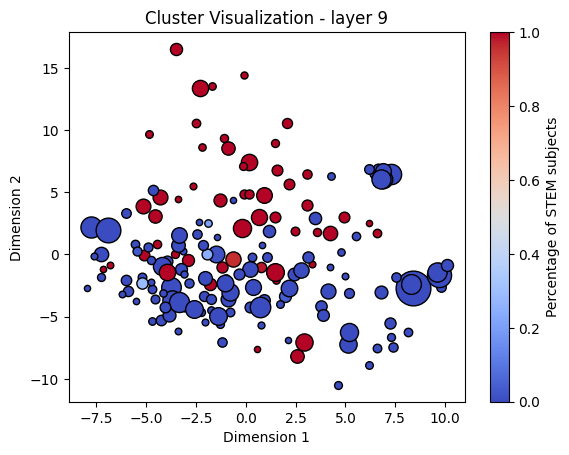

In [ ]:
# Example dataset and distance matrix
data_plot = cluster_sub
# distance_matrix = data.log_den_bord
distance_matrix = distance_matrix_euc_c
# Step 1: Count the points in each cluster
cluster_counts = Counter(data_plot[:, 1])

# Prepare counts and labels sorted by cluster index
clusters, counts = zip(*sorted(cluster_counts.items()))

# Step 2: Apply MDS to get 2D positions for each cluster
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions = mds.fit_transform(distance_matrix)

# Step 3: Plot each cluster as a circle with area proportional to the count of points
fig, ax = plt.subplots()
# colors = {'STEM': 'blue', 'Non-STEM': 'red'}  # Colors for stem and not stem

# Normalize the color map based on STEM percentages
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.coolwarm  # You can choose any other colormap as needed
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Convert percentages to colors
cluster_colors = scalar_map.to_rgba(most_represented["percentage"])

for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
    # ax.scatter(pos[0], pos[1], s=count, label=f'Cluster {cluster} (n={count})')
    # label = "STEM" if map_ind_sub[sub] in stem_subjects else "Non-STEM"ab
    ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
# from matplotlib.lines import Line2D
# custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['STEM'], markersize=10, label='STEM'),
#                  Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Non-STEM'], markersize=10, label='Non-STEM')]

# Enhance the plot
ax.set_title('Cluster Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(title='Cluster ID (STEM%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
#ax.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 1))
plt.title(f"Cluster Visualization - layer {layer}") 
# Show plot
plt.show()


RBF kernel

In [ ]:
distance_matrix_euc_c

array([[ 0.  ,  6.65, 12.67, ..., 12.33, 12.55, 12.6 ],
       [ 6.65,  0.  , 12.47, ..., 12.48, 13.06, 13.1 ],
       [12.67, 12.47,  0.  , ...,  5.28,  7.32,  7.88],
       ...,
       [12.33, 12.48,  5.28, ...,  0.  ,  6.01,  6.39],
       [12.55, 13.06,  7.32, ...,  6.01,  0.  ,  2.47],
       [12.6 , 13.1 ,  7.88, ...,  6.39,  2.47,  0.  ]])

In [ ]:
gamma = 0.0001
distance_matrix = distance_matrix_euc_c
#kernel_matrix = np.exp(-gamma *(distance_matrix) ** 2)
from sklearn.metrics.pairwise import rbf_kernel
kernel_matrix = rbf_kernel(centroids,gamma=gamma)
# from sklearn.metrics.pairwise import polynomial_kernel
# kernel_matrix = polynomial_kernel(distance_matrix, degree=6)
# from sklearn.metrics.pairwise import sigmoid_kernel
# kernel_matrix = sigmoid_kernel(distance_matrix,gamma=gamma)
# from sklearn.metrics.pairwise import linear_kernel
# kernel_matrix = linear_kernel(distance_matrix_euc_c)
# from sklearn.metrics.pairwise import chi2_kernel
# kernel_matrix = chi2_kernel(distance_matrix, gamma=0.00001)
# from sklearn.metrics.pairwise import laplacian_kernel
# kernel_matrix = laplacian_kernel(distance_matrix, gamma=gamma)

In [ ]:
kpca = KernelPCA(n_components=4, kernel='precomputed')

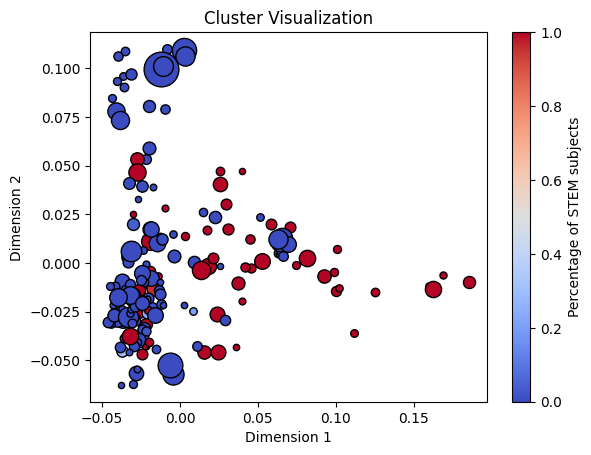

In [ ]:
# Example dataset and distance matrix
data_plot = cluster_sub
# distance_matrix = data.log_den_bord

# Step 1: Count the points in each cluster
cluster_counts = Counter(data_plot[:, 1])

# Prepare counts and labels sorted by cluster index
clusters, counts = zip(*sorted(cluster_counts.items()))

positions = kpca.fit_transform(kernel_matrix)

# Step 3: Plot each cluster as a circle with area proportional to the count of points
fig, ax = plt.subplots()
# colors = {'STEM': 'blue', 'Non-STEM': 'red'}  # Colors for stem and not stem

# Normalize the color map based on STEM percentages
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.coolwarm  # You can choose any other colormap as needed
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Convert percentages to colors
cluster_colors = scalar_map.to_rgba(most_represented["percentage"])


for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
    # ax.scatter(pos[0], pos[1], s=count, label=f'Cluster {cluster} (n={count})')
    # label = "STEM" if map_ind_sub[sub] in stem_subjects else "Non-STEM"
    ax.scatter(pos[0], pos[1], s= count, color=color, edgecolors='black', linewidth=1)
# from matplotlib.lines import Line2D
# custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['STEM'], markersize=10, label='STEM'),
#                  Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Non-STEM'], markersize=10, label='Non-STEM')]

# Enhance the plot
ax.set_title('Cluster Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(title='Cluster ID (STEM%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
#ax.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 1))

# Show plot
plt.show()

In [ ]:
distance_matrix

array([[ 0.  ,  6.65, 12.67, ..., 12.33, 12.55, 12.6 ],
       [ 6.65,  0.  , 12.47, ..., 12.48, 13.06, 13.1 ],
       [12.67, 12.47,  0.  , ...,  5.28,  7.32,  7.88],
       ...,
       [12.33, 12.48,  5.28, ...,  0.  ,  6.01,  6.39],
       [12.55, 13.06,  7.32, ...,  6.01,  0.  ,  2.47],
       [12.6 , 13.1 ,  7.88, ...,  6.39,  2.47,  0.  ]])

### Density rbf

In [ ]:
def double_centering(M):
    N = M.shape[0]

    Mc = - 0.5 * (M - 1. / N * np.sum(M, axis=0)[None, :] - 1. / N * np.sum(M, axis=1)[:,
                                                                     None] + 1. / N ** 2 * np.sum(M))

    return Mc

In [ ]:
def kernel_PCA(layer):
    # obtain distance matrix from density peaks and saddle points
    distances = max(layer.log_den) - layer.log_den_bord
    distances[np.diag_indices_from(distances)] = 0.

    if distances.shape[0] < 2:
        return np.array([[0, 0]])

    else:
        # compute average distance to set lengthscae of gaussian kernel
        md = np.mean(distances[np.triu_indices_from(distances)])
        sig = np.mean(md)

        # compute kernel matrix
        ker = np.exp(- distances ** 2 / (0.5 * sig ** 2))
        ker = double_centering(-ker)

        e, v = np.linalg.eigh(ker)
        s = np.argsort(e)[::-1]
        out = v[:, s[:2]]

        return out

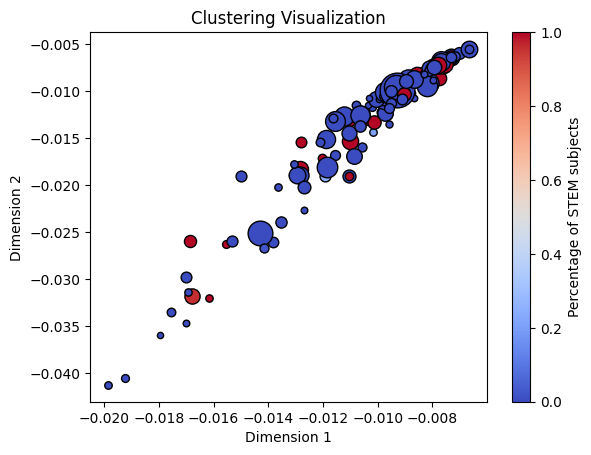

In [ ]:

# Example dataset and distance matrix
data_plot = cluster_sub
# distance_matrix = data.log_den_bord
distance_matrix = distance_matrix_euc_c
# Step 1: Count the points in each cluster
cluster_counts = Counter(data_plot[:, 1])

# Prepare counts and labels sorted by cluster index
clusters, counts = zip(*sorted(cluster_counts.items()))

positions = kernel_PCA(data)

# Step 3: Plot each cluster as a circle with area proportional to the count of points
fig, ax = plt.subplots()
# colors = {'STEM': 'blue', 'Non-STEM': 'red'}  # Colors for stem and not stem

# Normalize the color map based on STEM percentages
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.coolwarm  # You can choose any other colormap as needed
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Convert percentages to colors
cluster_colors = scalar_map.to_rgba(most_represented["percentage"])

for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
    # ax.scatter(pos[0], pos[1], s=count, label=f'Cluster {cluster} (n={count})')
    # label = "STEM" if map_ind_sub[sub] in stem_subjects else "Non-STEM"ab
    ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
# from matplotlib.lines import Line2D
# custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['STEM'], markersize=10, label='STEM'),
#                  Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Non-STEM'], markersize=10, label='Non-STEM')]

# Enhance the plot
ax.set_title('Clustering Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(title='Cluster ID (STEM%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
#ax.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 1))

# Show plot
plt.show()